# Load the pred_T file and the gold file

In [1]:
# pred_file = 'analysis/predT_not_in_original_pmid_predTs.json'
gold_file = 'data/KD-DTI/raw/test.json'
pmid = 'data/KD-DTI/raw/relis_test.pmid'
interactions_file = 'data/KD-DTI/raw/interactions'

In [2]:
import json

# load the gold standard
with open (gold_file, 'r') as f:
    gold_d = json.load(f)

print(len(gold_d))

# load the pmid
pmids = []
with open (pmid, 'r') as f:
    for line in f:
        line = line.rstrip()
        pmids.append(line)

print(len(pmids))

1159
1159


# Load the model

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from src.transformer_lm_prompt import TransformerLanguageModelPrompt
m = TransformerLanguageModelPrompt.from_pretrained(
        "checkpoints/RE-DTI-BioGPT", 
        "checkpoint_avg.pt", 
        "data/KD-DTI/relis-bin",
        tokenizer='moses', 
        bpe='fastbpe', 
        bpe_codes="data/bpecodes",
        max_len_b=1024,
        beam=5)
m.cuda()

2023-05-15 14:46:29 | INFO | fairseq.file_utils | loading archive file checkpoints/RE-DTI-BioGPT
2023-05-15 14:46:29 | INFO | fairseq.file_utils | loading archive file data/KD-DTI/relis-bin
2023-05-15 14:46:30 | INFO | src.language_modeling_prompt | dictionary: 42384 types
2023-05-15 14:46:34 | INFO | fairseq.models.fairseq_model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'user_dir': '../../src', 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False

GeneratorHubInterface(
  (models): ModuleList(
    (0): TransformerLanguageModelPrompt(
      (decoder): TransformerDecoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(42393, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layers): ModuleList(
          (0-23): 24 x TransformerDecoderLayerBase(
            (dropout_module): FairseqDropout()
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (activation_dropout_module): FairseqDropout()
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwis

In [4]:
# because it's hard to use the moses tokenizer.decode() to show the different between the 4 (= 4#) and 4</w>
# so here using the tokenizer from HF to decode each generated token, and it doesn't include the learn0 - learn9, which is not a problem
from transformers import BioGptTokenizer

tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")

/home/tian/mambaforge/envs/BioGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NER with ScispaCy, en_ner_bionlp13cg_md

pip install scispacy
 
a small English model:

pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz

In [5]:
import spacy

nlp = spacy.load("en_ner_bionlp13cg_md")

/home/tian/mambaforge/envs/BioGPT/lib/python3.10/site-packages/spacy/util.py:887: UserWarning: [W095] Model 'en_ner_bionlp13cg_md' (0.5.1) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.5.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# Adjust the data-preprocessing

In [6]:
def get_test_data(id):
    prefix = torch.arange(42384, 42393)
    test_data = {}
    test_data['pmid'] = pmids[id]
    test_data['text'] = gold_d[test_data['pmid']]['title'].strip() + " " + gold_d[test_data['pmid']]['abstract']
    if type(test_data['text'][-1]) is int:
    # no too long text
        if len(test_data['text']) > 800:
            test_data['text'] = test_data['text'][:800]
        test_data['text_tokens'] = torch.Tensor(test_data['text']).long()

    # for tokenization optimized input file
    else:
            # no too long text
        if len(test_data['text']) > 4500:
            test_data['text'] = test_data['text'][:4500]
    # get the entity with NER
    original_entities = nlp(test_data['text'].strip().replace('  ', ' '))
    # get no-duplicate and lower entities
    test_data['entities'] = list(set([entity.text.lower() for entity in original_entities.ents]))
    test_data['entity_tokens'] = [m.encode(entity)[:-1] for entity in test_data['entities']]
    test_data['text'] = test_data['text'].lower().strip().replace('  ', ' ')
    # no "2" in the end
    test_data['text_tokens'] = m.encode(test_data['text'])[:-1]
    test_data['text_tokens_with_prefix'] = torch.cat([test_data['text_tokens'], prefix], dim=-1).unsqueeze(0).cuda()
    test_data['gold_triples'] = gold_d[test_data['pmid']]['triples']
    return test_data

In [7]:
test_data = get_test_data(230)

print(test_data["gold_triples"])
# print(f'"gold": {test_data["gold_triples"][0]},')
print(f'"text": "{test_data["text"]}"\n')
print(f'"entities": {test_data["entities"]}\n')

[{'drug': '(-)-Tolserine', 'target': 'Acetylcholinesterase (AChE)', 'interaction': 'inhibitor'}, {'drug': '(-)-Phenserine', 'target': 'Acetylcholinesterase (AChE)', 'interaction': 'inhibitor'}, {'drug': '(-)-Tolserine', 'target': 'Cholinesterase (BCHE)', 'interaction': 'inhibitor'}, {'drug': '(-)-Phenserine', 'target': 'Cholinesterase (BCHE)', 'interaction': 'inhibitor'}]
"text": "long-acting anticholinesterases for myasthenia gravis: synthesis and activities of quaternary phenylcarbamates of neostigmine, pyridostigmine and physostigmine. the n-monophenylcarbamate analogues of neostigmine methyl sulfate (6) and pyridostigmine bromide (8) together with their precursors (5), (7), and the n(1)-methylammonium analogues of (-)-phenserine (12), (-)-tolserine (14), (-)-cymserine (16) and (-)-phenethylcymserine (18) were synthesized to produce long-acting peripheral inhibitors of acetylcholinesterase or butyrylcholinesterase. evaluation of their cholinesterase inhibition against human enzyme e

# Next D/T/I token

In [8]:
class interaction_tokens():
    def __init__(self, interactions_file='data/KD-DTI/raw/interactions', file=True):
        if file:
            interactions = []
            with open (interactions_file, 'r') as f:
                for line in f:
                    line = line.rstrip()
                    interactions.append(line)
            interaction_tokens = [tokenizer.encode(interaction, add_special_tokens=False) for interaction in interactions]
        else:
            interaction_tokens = interactions_file

        
        self.interaction_dict = {"[0]":[]}
        for token_ids in interaction_tokens:
            ids = []
            for i, id in enumerate(token_ids):
                ids += [id]
                if i == 0:
                    self.interaction_dict["[0]"].append(id)
                try:
                    if str(ids) in self.interaction_dict.keys():
                        self.interaction_dict[str(ids)].append(token_ids[i+1])
                    else:
                        self.interaction_dict[str(ids)] = [token_ids[i+1]]
                except:
                    if str(ids) not in self.interaction_dict.keys():
                        self.interaction_dict[str(ids)] = None
        self.interaction_dict["[0]"] = list(set(self.interaction_dict["[0]"]))

In [9]:
# predict the drug
def drug_target_prediction(
        output_text,
        test_input,
        drugs,
        targets,
        drug_target_pairs,
        step, 
        max_step,
        prob,
        ranking,
        m,
        tokenizer,
        entity_tokens,
        and_id=tokenizer.encode("and", add_special_tokens=False)[0],
        is_id=tokenizer.encode("is", add_special_tokens=False)[0],
        min_prob=0.02):

    def next_entity_token(output_text, possible_entity_token, tokens, drug=False, target=False):
        interaction_token_ids = possible_entity_token
        
        if drug:
            start_id = tokenizer.encode("between", add_special_tokens=False)[0]
            end_id = tokenizer.encode("and", add_special_tokens=False, return_tensors="pt").squeeze(0)
        else:
            start_id = tokenizer.encode("and", add_special_tokens=False)[0]
            end_id = tokenizer.encode("is", add_special_tokens=False, return_tensors="pt").squeeze(0)

        # if it's the first output of interaction tokens
        if len(tokens) == 0:
            return interaction_token_ids.interaction_dict["[0]"]
        
        else:
            current_output = [torch.tensor(token_id).cpu() for token_id in tokens]
            # print("current_output: ", current_output)
            assert str(current_output) in interaction_token_ids.interaction_dict.keys()
            if interaction_token_ids.interaction_dict[str(current_output)] is None:
                return end_id
            else:
                return interaction_token_ids.interaction_dict[str(current_output)]

    
     # drug 
    last_output_text = [x.clone() for x in output_text]
    last_test_input = test_input.clone()
    last_step = step
    last_prob = prob
    last_ranking = ranking

    possible_entity_token = interaction_tokens(entity_tokens, file=False)

    choose_which_drug = 0
    need_to_predict_new_drug = False

    while(step < max_step):
        drug_token_ids = []
        first_token = True
        choose_which = 0
        while(step < max_step):
            # drug (single entity mode)
            next_token_in_entity = next_entity_token(output_text, possible_entity_token, drug_token_ids,drug=True, target=False)
            # print("possible next drug token:", next_token_in_entity)
            step += 1
            out = m.models[0].decoder(test_input)
            softmax_out = torch.softmax(out[0][0][-1], dim=-1)
            top_k_probs, top_k_indices = torch.topk(softmax_out, len(softmax_out))
            if len(next_token_in_entity) > 1:
                choose_which = 0
                for i, token in enumerate(top_k_indices):
                    # choose_which_drug > 0 means to choose the second highest prob token
                    # but only the first token of the drug
                    # so here we set a flag to identify the first token of the drug: first_token
                    if token in next_token_in_entity:
                        if token in next_token_in_entity:
                            if not first_token:
                                next_token_id = i + 1
                                break
                            else:
                                if choose_which < choose_which_drug:
                                    choose_which += 1
                                else:
                                    if top_k_probs[i].item() >= min_prob:
                                        next_token_id = i + 1
                                    else:
                                        print(f"no more possible drugs, the process will stop here.")
                                        return None
                                    break
                test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
                output_text.append(top_k_indices[next_token_id-1])
                drug_token_ids.append(top_k_indices[next_token_id-1].item())
            else:
                # print("only one choice: ", next_token_in_entity)
                next_token_id = next_token_in_entity[-1].cuda()
                test_input = torch.cat([test_input[0], next_token_id.unsqueeze(0)], dim=-1).unsqueeze(0)
                output_text.append(next_token_id)
                drug_token_ids.append(next_token_id.item())

            first_token = False

            # prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
            # ranking.append(next_token_id)
            if output_text[-1] == and_id:
                print(f'drug: {m.decode(output_text)}\n')
                drugs.append(drug_token_ids[:-1])
                break
            

        # target
        target_token_ids = []
        no_target_output_text = [x.clone() for x in output_text]
        no_target_step = step
        no_target_input = test_input.clone()
        choose_which_target = 0

        # a flag to identify the first token of the target
        first_token = True

        # a flag to identify if there is need to predict a new drug instead of current drug
        need_to_predict_new_drug = False

        while(step < max_step):
            # target (single entity mode)
            next_token_in_entity = next_entity_token(output_text, possible_entity_token, target_token_ids, drug=False, target=True)
            # print("possible next target token:", next_token_in_entity)
            step += 1
            # print("shape of test_input: ", test_input.shape)
            out = m.models[0].decoder(test_input)
            softmax_out = torch.softmax(out[0][0][-1], dim=-1)
            top_k_probs, top_k_indices = torch.topk(softmax_out, len(softmax_out))
            if len(next_token_in_entity) > 1:
                choose_which = 0
                for i, token in enumerate(top_k_indices):
                    # choose_which_target > 0 means to choose the second highest prob token
                    # but only the first token of the target
                    # so here we set a flag to identify the first token of the target
                    if token in next_token_in_entity:
                        if token in next_token_in_entity:
                            if not first_token:
                                next_token_id = i + 1
                                break
                            else:
                                if choose_which < choose_which_target:
                                    choose_which += 1
                                else:
                                    if len(drug_target_pairs) < 1:
                                        next_token_id = i + 1
                                    else:
                                        if top_k_probs[i].item() >= min_prob:
                                            next_token_id = i + 1
                                        else:
                                            print(f"no more possible targets for {m.decode(drugs[-1])}, try to predict a new drug...")
                                            need_to_predict_new_drug = True
                                    break
                # if there is no possible target for current drug, then we need to predict a new drug, stop the while loop for target and go to continue
                if need_to_predict_new_drug:
                    break


                test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
                output_text.append(top_k_indices[next_token_id-1])
                target_token_ids.append(top_k_indices[next_token_id-1].item())
            else:
                # print("only one choice: ", next_token_in_entity)
                next_token_id = next_token_in_entity[-1].cuda()
                test_input = torch.cat([test_input[0], next_token_id.unsqueeze(0)], dim=-1).unsqueeze(0)
                output_text.append(next_token_id)
                target_token_ids.append(next_token_id.item())

            first_token = False

            # prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
            # ranking.append(next_token_id)
            if output_text[-1] == is_id:
                # print("is")
                pair = drug_token_ids[:-1] + target_token_ids[:-1]
                if pair not in drug_target_pairs:
                    # print("keep going")
                    print(f'target: {m.decode(output_text)}\n')
                    targets.append(target_token_ids[:-1])
                    drug_target_pairs.append(pair)

                    return output_text, test_input, step, drug_target_pairs#, prob, ranking
                
                else:
                    output_text = [x.clone() for x in no_target_output_text]
                    # step = no_target_step
                    test_input = no_target_input.clone()
                    # prob = no_target_prob
                    # ranking = last_ranking
                    choose_which_target += 1
                    print(f"duplicate target, try to predict {choose_which_target} target...")
                    print(f"new input: {m.decode(output_text)}")
                    first_token = True
                    target_token_ids = []


        if need_to_predict_new_drug:
            output_text = [x.clone() for x in last_output_text]
            test_input = last_test_input.clone()
            # step = last_step
            prob = last_prob
            ranking = last_ranking
            choose_which_drug += 1
            need_to_predict_new_drug = False
            continue
        else:
            print("something wrong, stop here.")
            return None

        

In [10]:
# predict interaction
def interaction_prediction(
        output_text,
        test_input,
        step, 
        max_step,
        prob,
        ranking,
        m,
        tokenizer,
        is_id,
        next_id,
        end_id,
        k
): 
    def next_interaction_token(output_text, inter_token_ids, is_id=is_id):
        interaction_token_ids = interaction_tokens()
        next_or_end_id = tokenizer.encode("; .", add_special_tokens=False)

        # if it's the first output of interaction tokens
        if len(inter_token_ids) < 1:
            return interaction_token_ids.interaction_dict["[0]"]
        
        else:

            current_output = [token_id.item() for token_id in inter_token_ids]
            assert str(current_output) in interaction_token_ids.interaction_dict.keys()
            if interaction_token_ids.interaction_dict[str(current_output)] is None:
                return next_or_end_id
            else:
                return interaction_token_ids.interaction_dict[str(current_output)]
            
    inter_token_ids = []
    while(step < max_step):
        print(f'output_text: {m.decode(output_text)}\n')
        
        next_word_in_original = next_interaction_token(output_text, inter_token_ids)
        # print("possible next interaction token:", next_word_in_original)
        step += 1
        # print("test_input: ", test_input)
        # print("length of test_input: ", len(test_input[0]))
        out = m.models[0].decoder(test_input)
        # print("out, ok")
        softmax_out = torch.softmax(out[0][0][-1], dim=-1)
        # print("softmax, ok")
        _, top_k_indices = torch.topk(out[0][0][-1], k=k)
        # print("top-k, ok")
        for i, token in enumerate(top_k_indices):
            # print("top-k token:", i, token.item())
            if token.item() in next_word_in_original:
                next_token_id = i + 1
                break
        test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
        output_text.append(top_k_indices[next_token_id-1])
        inter_token_ids.append(top_k_indices[next_token_id-1].unsqueeze(0))
        # print(f'inter_token_ids: {inter_token_ids}\n')

        # prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
        # ranking.append(next_token_id)
        if output_text[-1] in [next_id, end_id]:
            print(f'output_text: {m.decode(output_text)}\n')
            break

    
    return output_text, test_input, step#, prob, ranking

# Inference

In [11]:
outputs = []

In [12]:
outputs = torch.load("outputs-562.pt")

In [13]:
len(outputs)

562

In [14]:
for n in range(562, len(pmids)):
    # initialize
    torch.cuda.empty_cache()
    test_data = get_test_data(n)
    test_input_original = test_data['text_tokens_with_prefix']
    test_input = test_data['text_tokens_with_prefix']
    test_text = test_data['text_tokens'].cuda()

    k = 8000

    between_id = tokenizer.encode("between", add_special_tokens=False)[0]
    and_id = tokenizer.encode("and", add_special_tokens=False)[0]
    is_id = tokenizer.encode("is", add_special_tokens=False)[0]
    next_id = tokenizer.encode(";", add_special_tokens=False)[0]
    end_id = tokenizer.encode(".", add_special_tokens=False)[0]
    output_text = []
    prob = []
    ranking = []
    step = 0
    max_step = 500
    num_tuples = 0
    drugs = []
    targets = []
    num_triplets = 0
    drug_target_pairs = []

    with torch.no_grad():
        m.models[0].decoder.eval()

        while(step < max_step):
            # # there is an unsolved bug for n = 706
            # if n == 706:
            #     output_text = [6, 639,45]
            #     break

            last_output_text = [x.clone() for x in output_text]
            last_prob = prob
            last_ranking = ranking
            last_step = step
            for i in range(3):
                step += 1

                out = m.models[0].decoder(test_input)

                softmax_out = torch.softmax(out[0][0][-1], dim=-1)
                _, top_k_indices = torch.topk(out[0][0][-1], k=k)
                top_k_tokens = [tokenizer.convert_ids_to_tokens([indice]) for indice in top_k_indices]
                top_k_probs = torch.softmax(out[0][0][-1][top_k_indices], dim=-1)
                top_k = [(token, prob.item()) for token, prob in zip(top_k_tokens, top_k_probs)]
                # print(f'The top-{k} most possible tokens are:\n{top_k}')
                next_token_id = 1
                test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
                output_text.append(top_k_indices[next_token_id-1])

                # prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
                # ranking.append(next_token_id)

            result = drug_target_prediction(
                output_text,
                test_input,
                drugs,
                targets,
                drug_target_pairs,
                step, 
                max_step,
                prob,
                ranking,
                m,
                tokenizer,
                test_data["entity_tokens"]
                )
            if result:
                output_text, test_input, step, drug_target_pairs = result
            else:
                if len(last_output_text) > 0:
                    output_text = [x.clone() for x in last_output_text]
                else:
                    output_text = [6, 639,45]
                print(f'The final output:{m.decode(output_text)}\n')
                break

            # print(f'output_text: {m.decode(output_text)}\n')

            if step >= max_step:
                print("Steps exceed the maximum steps")
                break

            # print("test_input after d&t: ", test_input)
            # interactions
            output_text, test_input, step = interaction_prediction(output_text, test_input, step,
                                                                    max_step, prob, ranking, m, tokenizer, is_id, next_id, end_id, k)
            
            num_triplets += 1
            if output_text[-1] == end_id or step >= max_step or num_triplets >= 3:
                if step >= max_step:
                    print("Steps exceed the maximum steps")
                break
            
    print(f"{n + 1}/{len(pmids)}")
    outputs.append(output_text)
    print("lenght of outputs: ", len(outputs))
    print("final outputs: ", output_text)
    assert len(outputs) == n + 1
    if n % 20 == 0:
        output_triplets = [m.decode(hypos) for hypos in outputs]
        with open(f"{'examples/RE-DTI/generate_checkpoint_optimized_3-NER.pt'}", "w", encoding='utf8') as fw:
            for i in range(len(output_triplets)):
                fw.write(output_triplets[i] + '\n')    
    


drug: the interaction between triprolidine and

target: the interaction between triprolidine and histamine is

output_text: the interaction between triprolidine and histamine is

output_text: the interaction between triprolidine and histamine is antagonist

output_text: the interaction between triprolidine and histamine is antagonist.

563/1159
lenght of outputs:  563
final outputs:  [tensor(6, device='cuda:0'), tensor(639, device='cuda:0'), tensor(45, device='cuda:0'), tensor(2175, device='cuda:0'), tensor(21326, device='cuda:0'), tensor(4688, device='cuda:0'), tensor(8, device='cuda:0'), tensor(3720, device='cuda:0'), tensor(21, device='cuda:0'), tensor(1860, device='cuda:0'), tensor(4, device='cuda:0')]
drug: the interaction between azelaic acid and

target: the interaction between azelaic acid and thioredoxin reductase is

output_text: the interaction between azelaic acid and thioredoxin reductase is

output_text: the interaction between azelaic acid and thioredoxin reductase is in

In [15]:
print(len(outputs))
torch.save(outputs, f"outputs-{n}.pt")

1159


In [21]:
output_triplets = [m.decode(hypos) for hypos in outputs]
with open(f"{'examples/RE-DTI/generate_checkpoint_optimized_3-NER.pt'}", "w", encoding='utf8') as fw:
    for i in range(len(output_triplets)):
        fw.write(output_triplets[i] + '\n')

In [24]:
output_triplets = [m.decode(hypos) for hypos in outputs]

In [25]:
len(output_triplets)

3

In [26]:
output_triplets

['the interaction between psoralen and monoamine oxidase is inhibitor;',
 'the interaction between pnu156804 and janus kinase 3 is inhibitor.',
 'the interaction between thiorphan and nep is inhibitor.']

In [41]:
test_data["gold_triples"]

[{'drug': 'Lisinopril',
  'target': 'Angiotensin-converting enzyme (ACE)',
  'interaction': 'inhibitor'}]

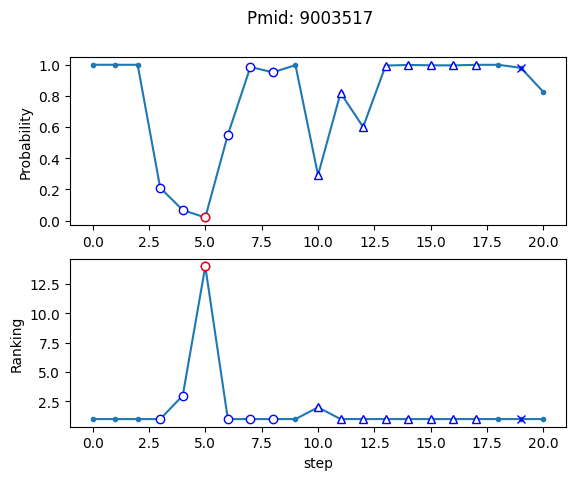

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Create some fake data.
x = np.arange(step-1)
y1 = prob
y2 = ranking

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle(f'Pmid: {test_data["pmid"]}')

ax1.plot(x, y1, '.-')
ax1.set_ylabel('Probability')

ax2.plot(x, y2, '.-')
ax2.set_xlabel('step')
ax2.set_ylabel('Ranking')

marks = [0]* (step-1)
mark = False

# 0 for  parttern tokens, 1 for drugs ,2 for targets, 3 for interaction
for i, token in enumerate(output_text):
    if token != 6 and output_text[i-1] == 45:
        marks[i] = 1
        mark = True
        continue
    if token == 8 or token == 21 or token == 4:
        continue
    if token != 6 and output_text[i-1] == 8:
        marks[i] = 2
        mark = True
        continue
    if token != 6 and output_text[i-1] == 21:
        marks[i] = 3
        mark = True
        continue
    if token == 44:
        mark = False
        continue
    if mark:
        marks[i] = marks[i-1]
        

# if marks[x] == 1, then using hollow circle for the plot, if marks[x] == 2, then using hollow triangle for the plot, if marks[x] == 3, then using star for the plot.
for i in range(step-1):
    if marks[i] == 1:
        ax1.plot(x[i], y1[i], marker='o', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='o', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='o', color='white', markeredgecolor='red')
            ax2.plot(x[i], y2[i], marker='o', color='white', markeredgecolor='red')

    if marks[i] == 2:
        ax1.plot(x[i], y1[i], marker='^', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='^', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='^', color='red')
            ax2.plot(x[i], y2[i], marker='^', color='red')

    if marks[i] == 3:
        ax1.plot(x[i], y1[i], marker='x', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='x', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='x', color='red')
            ax2.plot(x[i], y2[i], marker='x', color='red')


plt.savefig(f'analysis/img/{test_data["pmid"]}-*.png')
plt.show()